In [1]:
import numpy as np
import pandas as pd

In [2]:
import time
import os
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
import torch.utils.data as data


import torchvision
import torchvision.transforms as transforms
import torchvision.models as models



In [3]:
torch.cuda.is_available()

True

## Defining Pytorch Dataset and Dataloader:

In [4]:
train = pd.read_csv('/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv')
test = pd.read_csv('/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv')

In [5]:
class SignLanguageDataset(data.Dataset):
    
    def __init__(self, df, transform=None):
        
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index):
        
        label = self.df.iloc[index, 0]
        
        img = self.df.iloc[index, 1:].values.reshape(28, 28)
        img = torch.Tensor(img).unsqueeze(0)
        if self.transform is not None:
            img =self.transform(img)
        
        return img, label
        

In [6]:
def show_img(img, label):
    img = img.squeeze()
    img = img*40. + 159.
    imgnp = img.detach().numpy()
    plt.imshow(img, interpolation='bicubic')
    print(label)

In [7]:
transforms4train = transforms.Compose([
        #transforms.Normalize(159, 40),
        transforms.RandomHorizontalFlip(p=0.1),
        transforms.RandomApply([transforms.RandomRotation(degrees=(-180, 180))], p=0.2),
]) 

In [8]:
train_dataset = SignLanguageDataset(train, transform=transforms4train)
test_dataset = SignLanguageDataset(test)

In [9]:
len(train_dataset), len(test_dataset)

(27455, 7172)

In [10]:
train_loader = data.DataLoader(train_dataset, batch_size=200, shuffle=True, num_workers=2)
test_loader = data.DataLoader(test_dataset, batch_size=200, shuffle=True, num_workers=2)

In [11]:
trainiter = iter(train_loader)
img, label = next(trainiter)
print(img.shape)

torch.Size([200, 1, 28, 28])


tensor(22)


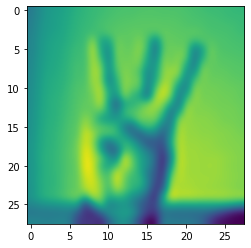

In [12]:
show_img(img[10], label[10])

In [13]:
def calc_out_size(img_size, kernel_size, stride=1, padding=1, dilation=1 ):
    out_size = ((img_size + 2*padding - (dilation*(kernel_size-1) +1 )) / stride) + 1
    return int(out_size)

In [14]:
calc_out_size(28, 3)

28

## Making simple custom convolution net:

In [15]:
class MyConvNet(nn.Module):
    
    def __init__(self, stride=1, dilation=1, n_classes=25):
        
        super(MyConvNet, self).__init__()
        
        self.stride = stride
        self.dilation = dilation
        self.n_classes = n_classes
        
        self.block1 = nn.Sequential(
            #input=(batch, 1, 28, 28)
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1, stride=self.stride, dilation=self.dilation),
            nn.BatchNorm2d(8),
            # (batch, 8, 28, 28)
            nn.AvgPool2d(2),
            # (batch, 8, 14, 14)
            nn.ReLU()
            )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=self.stride, dilation=self.dilation),
            nn.BatchNorm2d(16),
            # (batch, 16, 14, 14)
            nn.AvgPool2d(2),
            # (batch, 16, 7, 7)
            nn.ReLU()
        )
        
        self.lin1 = nn.Linear(in_features=16*7*7, out_features=100)
        # (batch, 100)
        self.act1 = nn.LeakyReLU()
        self.drop1 = nn.Dropout(p=0.3)
        self.lin2 = nn.Linear(100, self.n_classes)
        # (batch, 25)
    
    def forward(self, x):
        
        x = self.block1(x)
        x = self.block2(x)
        x = x.view((x.shape[0], -1))
        x = self.lin1(x)
        x = self.act1(x)
        x = self.drop1(x)
        x = self.lin2(x)
        
        return x

In [16]:
model = MyConvNet()
model

MyConvNet(
  (block1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): ReLU()
  )
  (block2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): ReLU()
  )
  (lin1): Linear(in_features=784, out_features=100, bias=True)
  (act1): LeakyReLU(negative_slope=0.01)
  (drop1): Dropout(p=0.3, inplace=False)
  (lin2): Linear(in_features=100, out_features=25, bias=True)
)

In [17]:
sample_batch = torch.ones(20, 1, 28, 28)
print(model.block1(sample_batch).shape)
print(model.block2(model.block1(sample_batch)).shape)
print(model(sample_batch).shape)

torch.Size([20, 8, 14, 14])
torch.Size([20, 16, 7, 7])
torch.Size([20, 25])


## Defining our training and evaluation pipeline:

In [18]:
def eval_model(model, criterion, test_loader, cuda=True):
    
    if cuda:
        model = model.cuda()
    
    model = model.eval()
    
    running_loss = 0.
    num_correct = 0.
    num_total = 0.
    
    for batch, labels in test_loader:
        
        if cuda:
            batch = batch.cuda()
            labels = labels.cuda()
        
        out = model(batch)
        pred_labels = out.argmax(dim=1)
        num_correct += float((pred_labels == labels).sum())
        
        loss = criterion(out, labels)
        running_loss += loss.data.cpu()
        
        num_total += labels.shape[0]
    
    mean_loss = running_loss / num_total
    accuracy = num_correct / num_total
    
    return mean_loss, accuracy
        
        

In [19]:
def train_model(n_epochs, model, optimizer, criterion, train_loader, test_loader, cuda=True):
    
    if cuda:
        model = model.cuda()
    
    model = model.train()
    
    train_loss, train_acc = [], []
    test_loss, test_acc = [], []
    
    for epoch in range(n_epochs):
        t0 = time.perf_counter()
        
        running_loss = 0.
        num_correct = 0.
        num_total = 0.
        
        for batch, labels in train_loader:
            if cuda:
                batch = batch.cuda()
                labels = labels.cuda()
            
            optimizer.zero_grad()
            
            out = model(batch)
            pred_labels = out.argmax(dim=1)
            num_correct += float((pred_labels == labels).sum())
            num_total += labels.shape[0]
            
            
            
            loss = criterion(out, labels)
            running_loss += loss
            loss.backward()
            optimizer.step()
        
        epoch_loss = running_loss / num_total
        epoch_acc = num_correct / num_total
        
        train_loss.append(epoch_loss.data.cpu())
        train_acc.append(epoch_acc)
        
        t_loss, t_acc = eval_model(model, criterion, test_loader, cuda=True)
        
        test_loss.append(t_loss.data.cpu())
        test_acc.append(t_acc)
        
        t1 = time.perf_counter()
        
        delta_t = t1 - t0
        print(f"EPOCH {epoch} ({round(delta_t, 4)} s.): train loss - {epoch_loss}, train accuracy - {epoch_acc}; test loss - {t_loss}, test accuracy - {t_acc}")
        
    
    return model, train_loss, train_acc, test_loss, test_acc        
        
        

In [20]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [21]:
model, train_loss, train_acc, test_loss, test_acc = train_model(20, model, optimizer, criterion, train_loader, test_loader, cuda=True)

EPOCH 0 (13.6622 s.): train loss - 0.01043976005166769, train accuracy - 0.4022218175195775; test loss - 0.0046991994604468346, test accuracy - 0.7208588957055214
EPOCH 1 (13.328 s.): train loss - 0.004636584315448999, train accuracy - 0.735785831360408; test loss - 0.0024069873616099358, test accuracy - 0.8305911879531511
EPOCH 2 (12.7818 s.): train loss - 0.0032399604097008705, train accuracy - 0.8145692952103442; test loss - 0.0018713686149567366, test accuracy - 0.8735359732292247
EPOCH 3 (12.4363 s.): train loss - 0.002553358906880021, train accuracy - 0.8486250227645238; test loss - 0.0018530118977651, test accuracy - 0.8810652537646403
EPOCH 4 (13.0776 s.): train loss - 0.002263261703774333, train accuracy - 0.8646876707339283; test loss - 0.0017426207195967436, test accuracy - 0.8816229782487451
EPOCH 5 (12.8654 s.): train loss - 0.00201016990467906, train accuracy - 0.8757239118557639; test loss - 0.0018963732291013002, test accuracy - 0.8700501952035694
EPOCH 6 (13.3599 s.): 

Text(0.5, 1.0, 'Accuracy')

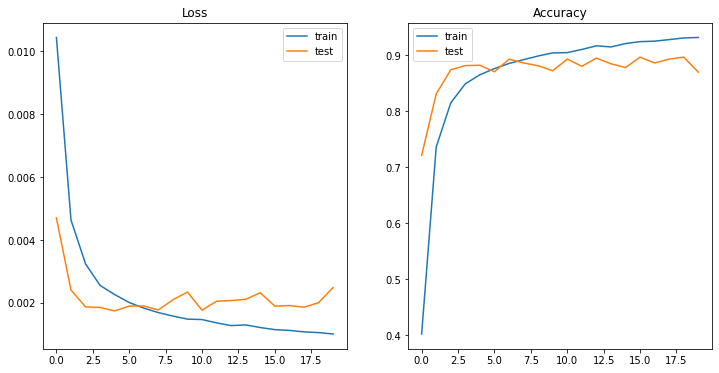

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.plot(train_loss)
ax1.plot(test_loss)
ax1.legend(['train', 'test'])
ax1.set_title('Loss')
ax2.plot(train_acc)
ax2.plot(test_acc)
ax2.legend(['train', 'test'])
ax2.set_title('Accuracy')

In [23]:
state = {'model': model.state_dict(),
        'epoch': 20}
torch.save(state, './myconvnet_sign_lang.pth')

In [24]:
testiter = iter(test_loader)
img, label = next(testiter)
model = model.cpu()

Fact: 20, Prediction: 17
tensor(20)


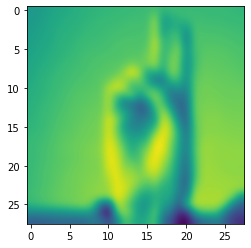

In [25]:
idx=12
pred = model(img)
print(f'Fact: {label[idx]}, Prediction: {(torch.argmax(pred[idx], dim=0))}')
show_img(img[idx], label[idx])

## Using ready ResNet18 architecture (with additional layers to match desired input and output sizes)

In [26]:
resnet18 = models.resnet18(pretrained=False)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
resnet18.fc = nn.Linear(in_features=512, out_features=25) 

In [28]:
resnet18_1channel = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1), 
                                resnet18)

In [29]:
smpl = torch.ones((10, 1, 28, 28))
resnet18_1channel(smpl).shape

torch.Size([10, 25])

In [30]:
optimizer = optim.Adam(resnet18_1channel.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [31]:
model, train_loss, train_acc, test_loss, test_acc = train_model(30, resnet18_1channel, optimizer, criterion, train_loader, test_loader, cuda=True)

EPOCH 0 (15.7967 s.): train loss - 0.004665434826165438, train accuracy - 0.7140411582589692; test loss - 0.008519317023456097, test accuracy - 0.6175404350250976
EPOCH 1 (16.7792 s.): train loss - 0.01605939120054245, train accuracy - 0.09823347295574576; test loss - 0.011737753637135029, test accuracy - 0.22894590072504184
EPOCH 2 (16.0218 s.): train loss - 0.009435907937586308, train accuracy - 0.38437443088690587; test loss - 0.005258876830339432, test accuracy - 0.6522587841606247
EPOCH 3 (16.9796 s.): train loss - 0.0046559409238398075, train accuracy - 0.7040611910398834; test loss - 0.002276057843118906, test accuracy - 0.8467651979921919
EPOCH 4 (16.1001 s.): train loss - 0.0029800995253026485, train accuracy - 0.8093607721726461; test loss - 0.0027613763231784105, test accuracy - 0.8601505856107083
EPOCH 5 (16.72 s.): train loss - 0.002519793575629592, train accuracy - 0.8337643416499727; test loss - 0.0017601699801161885, test accuracy - 0.8990518683770218
EPOCH 6 (15.8448 s